In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy
import copy

In [2]:

batch_size = 4

# Download the dataset and create the dataloaders
cifar_train = datasets.CIFAR10("./", train=True, download=True, transform=transforms.ToTensor())

##YOU MAY WANT TO ADD A WAY TO SPLIT THE DATASET HERE##
generator1 = torch.Generator().manual_seed(42)
vali_set = torch.utils.data.random_split(cifar_train, [0.2, 0.8], generator=generator1)[0]
train_set = torch.utils.data.random_split(cifar_train, [0.2, 0.8], generator=generator1)[1]
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
vali_loader = DataLoader(vali_set, batch_size=batch_size, shuffle=False, num_workers=2)

cifar_test = datasets.CIFAR10("./", train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 53592620.45it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


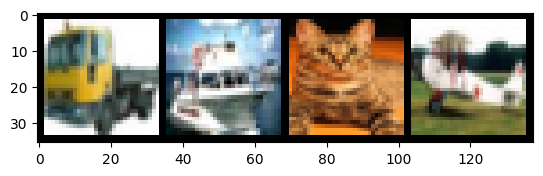

truck ship  cat   plane


In [3]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# functions to show an image


def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 3 input channels (RGB), 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling with 2x2 window and stride 2
        self.conv2 = nn.Conv2d(6, 16, 5)  # 6 input channels (from previous layer), 16 output channels, 5x5 kernel
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Fully connected layer with 16x5x5 input features
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # Output layer with 10 classes

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.leaky_relu(self.conv1(x)))  # Apply first convolution, ReLU activation, and max pooling
        # print("first pool",x.shape)
        x = self.pool(F.leaky_relu(self.conv2(x)))  # Apply second convolution, ReLU activation, and max pooling
        # print("second pool",x.shape)
        # Flatten the feature maps for fully connected layers
        x = x.view(-1, 16 * 5 * 5)

        # Fully connected layers
        x = F.leaky_relu(self.fc1(x))  # Apply first fully connected layer with ReLU activation
        x = F.leaky_relu(self.fc2(x))  # Apply first fully connected layer with ReLU activation
        x = self.fc3(x)  # Apply output layer (no activation for binary classification)

        return x

In [5]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    """
    Trains the given model using the specified data loaders.

    Args:
        model (nn.Module): The neural network model to train.
        criterion: Loss function (e.g., nn.CrossEntropyLoss for classification).
        optimizer: Optimizer (e.g., Adam, SGD) for updating model parameters.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        num_epochs (int): Number of training epochs.

    Returns:
        None
    """
    best_vloss = 10
    train_loss_lst = []
    vali_loss_lst = []
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0

        for (inputs, labels) in train_loader:
            # print("train label", labels)
            # inputs_aug = transform(inputs)
            inputs_aug = inputs

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs_aug)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            train_loss += loss.item()

        # Calculate average training loss for this epoch
        avg_train_loss = train_loss / (len(train_loader))

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0

        with torch.no_grad():
            for (inputs, labels) in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Calculate average validation loss for this epoch
        avg_vloss = val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_vloss:.4f}")

        if avg_vloss < best_vloss:
            # print("loss is small")
            best_vloss = avg_vloss
            model_path = 'model_{}_{}'.format(timestamp, epoch)
            torch.save(model.state_dict(), model_path)

        train_loss_lst.append(avg_train_loss)
        vali_loss_lst.append(avg_vloss)

    print("Training complete!")
    return model_path, train_loss_lst, vali_loss_lst

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def test(model, criterion, test_loader):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    test_loss = 0
    correct = 0

    y_pred = []
    y_true = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for (inputs, labels) in test_loader:
            y_true.extend(labels)
            outputs = model(inputs)
            # pred = torch.argmax(outputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
            y_pred.extend(predicted)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    correct = correct /len(test_loader.dataset)
    print(f"Validation set Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(confusion_matrix = cm,  display_labels=classes).plot()
    return test_loss, correct

In [7]:
# from torchvision.transforms import v2
import torch.optim as optim
from datetime import datetime

# SHUFFLE = ...
LEARNING_RATE = 1e-4
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')


# Load our network
model = Net()

# Define our loss function
# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()

# Define our optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay = 1e-5)
# Train the model
trained_model = train_model(model, criterion, optimizer, train_loader, vali_loader, 5)

Epoch [1/5] - Train Loss: 1.8729 - Val Loss: 1.7267
Epoch [2/5] - Train Loss: 1.5790 - Val Loss: 1.5120
Epoch [3/5] - Train Loss: 1.4711 - Val Loss: 1.3992
Epoch [4/5] - Train Loss: 1.3951 - Val Loss: 1.3334
Epoch [5/5] - Train Loss: 1.3349 - Val Loss: 1.2921
Training complete!


Validation set Error: 
 Accuracy: 46.6%, Avg loss: 1.465715 



(1.4657152282595634, 0.4657)

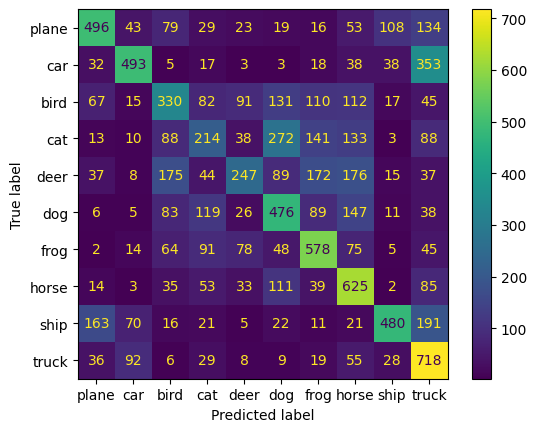

In [ ]:
test(model, criterion, test_loader)

In [8]:
# prepare to count predictions for each class
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 64.4 %
Accuracy for class: car   is 59.7 %
Accuracy for class: bird  is 27.9 %
Accuracy for class: cat   is 30.2 %
Accuracy for class: deer  is 49.9 %
Accuracy for class: dog   is 51.1 %
Accuracy for class: frog  is 56.2 %
Accuracy for class: horse is 69.8 %
Accuracy for class: ship  is 58.2 %
Accuracy for class: truck is 58.6 %
